# Google's Qiuck Draw Dataset, CNN Training and Analysis

In [2]:
import datetime, os
from pathlib import Path

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

# tensorflow imports :_)
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import sparse_categorical_accuracy
from tensorflow.keras.layers import Rescaling
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard

# this is a quickdraw api that allows us to download our data
from quickdraw import QuickDrawDataGroup, QuickDrawData

## Exploring Quick Draw API

In [3]:
QuickDrawData().drawing_names

['aircraft carrier',
 'airplane',
 'alarm clock',
 'ambulance',
 'angel',
 'animal migration',
 'ant',
 'anvil',
 'apple',
 'arm',
 'asparagus',
 'axe',
 'backpack',
 'banana',
 'bandage',
 'barn',
 'baseball bat',
 'baseball',
 'basket',
 'basketball',
 'bat',
 'bathtub',
 'beach',
 'bear',
 'beard',
 'bed',
 'bee',
 'belt',
 'bench',
 'bicycle',
 'binoculars',
 'bird',
 'birthday cake',
 'blackberry',
 'blueberry',
 'book',
 'boomerang',
 'bottlecap',
 'bowtie',
 'bracelet',
 'brain',
 'bread',
 'bridge',
 'broccoli',
 'broom',
 'bucket',
 'bulldozer',
 'bus',
 'bush',
 'butterfly',
 'cactus',
 'cake',
 'calculator',
 'calendar',
 'camel',
 'camera',
 'camouflage',
 'campfire',
 'candle',
 'cannon',
 'canoe',
 'car',
 'carrot',
 'castle',
 'cat',
 'ceiling fan',
 'cell phone',
 'cello',
 'chair',
 'chandelier',
 'church',
 'circle',
 'clarinet',
 'clock',
 'cloud',
 'coffee cup',
 'compass',
 'computer',
 'cookie',
 'cooler',
 'couch',
 'cow',
 'crab',
 'crayon',
 'crocodile',
 'crow

## Downloading Quick Draw dataset

In [4]:
IMAGE_SIZE = (28, 28) 
MAX_PER_CATEGORY = 800 # lol I have space limitations (used to be 10k)
DATASET_PATH = 'dataset/'
RECOGNIZED_ONLY = True

# using the quick draw data to download the images
for label in QuickDrawData().drawing_names:
    directory = Path(DATASET_PATH + label)
    png_files = list(directory.glob("*.png"))

    if not directory.exists():
        directory.mkdir(parents=True)
    else:
        # if folder is there but it doens't have all the files we need to check :P (I messed up here many times)
        if len(png_files) >= MAX_PER_CATEGORY:
            print(f"Skipping {label}, already has {len(png_files)} PNG files.")
            continue
        
        print(f"Processing {label}, found {len(png_files)} PNG files.")

    images = QuickDrawDataGroup(label, max_drawings=MAX_PER_CATEGORY, recognized=RECOGNIZED_ONLY)
    for img in images.drawings:
        filename = directory.as_posix() + "/" + str(img.key_id) + ".png"
        
        # lets check if we already have that file
        if filename.split("/")[:-1] in png_files:
            continue 
        
        # I need to resize the image to use it for our CNN Model
        img.get_image(stroke_width=3).resize(IMAGE_SIZE).save(filename)


Skipping aircraft carrier, already has 800 PNG files.
Skipping airplane, already has 800 PNG files.
Skipping alarm clock, already has 800 PNG files.
Skipping ambulance, already has 800 PNG files.
Skipping angel, already has 800 PNG files.
Skipping animal migration, already has 800 PNG files.
Skipping ant, already has 800 PNG files.
Skipping anvil, already has 800 PNG files.
Skipping apple, already has 800 PNG files.
Skipping arm, already has 800 PNG files.
Skipping asparagus, already has 800 PNG files.
Skipping axe, already has 800 PNG files.
Skipping backpack, already has 800 PNG files.
Skipping banana, already has 800 PNG files.
Skipping bandage, already has 800 PNG files.
Skipping barn, already has 800 PNG files.
Skipping baseball bat, already has 800 PNG files.
Skipping baseball, already has 800 PNG files.
Skipping basket, already has 800 PNG files.
Skipping basketball, already has 800 PNG files.
Skipping bat, already has 800 PNG files.
Skipping bathtub, already has 800 PNG files.


## Dataset pre-processing / visualization 

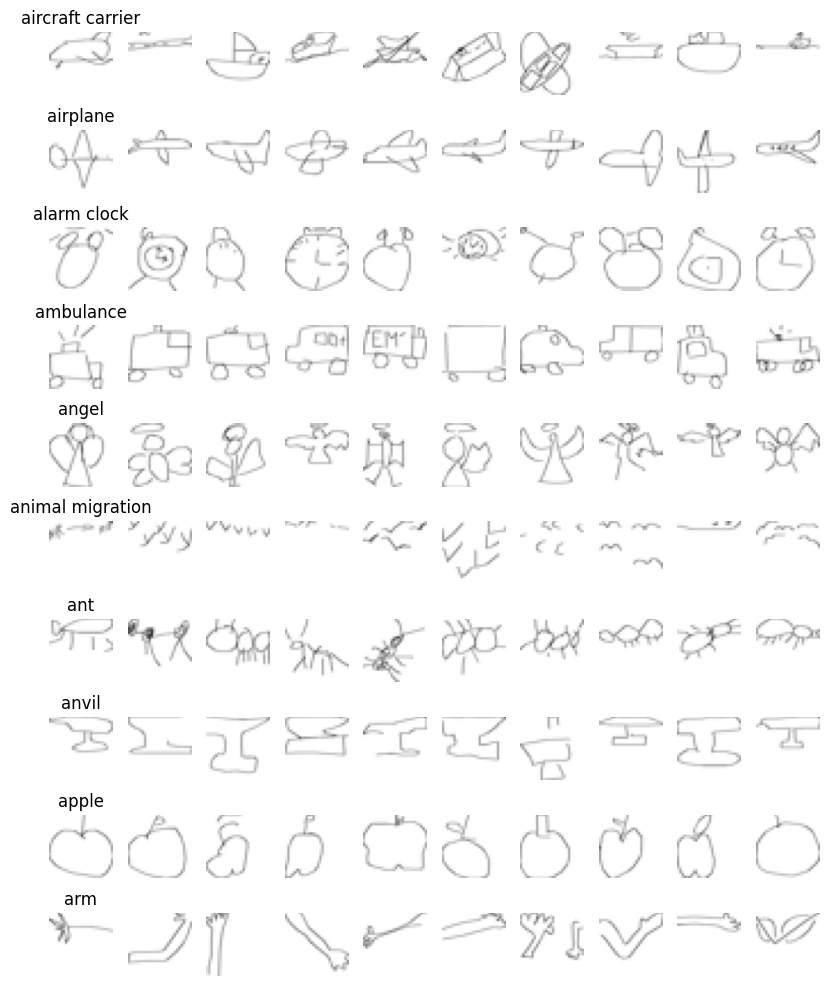

In [5]:
# lets take a look at the images!
def display_sample_images(data_path, categories, num_images=10):
    fig, axes = plt.subplots(len(categories), num_images, figsize=(8, len(categories)))
    for i, category in enumerate(categories):
        category_path = Path(data_path) / category
        image_files = list(category_path.glob("*.png"))[:num_images]
        for j, image_file in enumerate(image_files):
            img = plt.imread(image_file)
            ax = axes[i, j] if len(categories) > 1 else axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(category if j == 0 else "")
    plt.tight_layout()
    plt.show()

# we only want to see 10 categories
display_sample_images(DATASET_PATH, QuickDrawData().drawing_names[:10])

## Building CNN Model

In [6]:
BATCH_SIZE = 32
INPUT_SHAPE = (28, 28, 1)
NUM_CLASSES = 345

# creating a training dataset
train_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="training",
    seed=123,
    color_mode="grayscale",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# creating a validation dataset
val_ds = image_dataset_from_directory(
    "dataset",
    validation_split=0.2,
    subset="validation",
    seed=123,
    color_mode="grayscale",
    image_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE
)

# creating a squential dataset
model = Sequential([
    Rescaling(1. / 255, input_shape=INPUT_SHAPE),
    BatchNormalization(),

    Conv2D(6, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(8, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(10, kernel_size=(3, 3), padding="same", activation="relu"),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(700, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(500, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),

    Dense(400, activation='relu'),
    Dropout(0.2),

    Dense(NUM_CLASSES, activation='softmax')
])

# compiling our model for training
model.compile(
    optimizer="adam",
    loss=SparseCategoricalCrossentropy(), # https://rmoklesur.medium.com/what-you-need-to-know-about-sparse-categorical-cross-entropy-9f07497e3a6f#:~:text=Sparse%20categorical%20cross%2Dentropy%20is%20an%20extension%20of%20the%20categorical,a%20one%2Dhot%20encoded%20vector.
    metrics=["accuracy"]
)

# print out a summary for viewers :P
model.summary()

Found 276000 files belonging to 345 classes.
Using 220800 files for training.
Found 276000 files belonging to 345 classes.
Using 55200 files for validation.


C:\Users\alvaj\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 1)      │             4 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 6)      │            60 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 8)      │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 10)     │           730 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 28, 10)     │            40 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1960)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 700)            │     1,372,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 700)            │         2,800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 700)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 500)            │       350,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 500)            │         2,000 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 400)            │       200,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 400)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 345)            │       138,345 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,068,019 (7.89 MB)

 Trainable params: 2,065,597 (7.88 MB)

 Non-trainable params: 2,422 (9.46 KB)

## Training CNN Model

In [7]:
EPOCHS = 14

checkpoint_filepath = os.path.join("cnn/checkpoints/", "quickdraw_cnn_model.keras")

# i want to check if there is a path that exists that means we have preivous data
if Path(checkpoint_filepath).exists():
    print("Previous training data was found!")
    
    user_input = input("Would you like to start where you left off? (Y/n)")
    if user_input == "y" or user_input == "Y": 
        model = tf.keras.models.load_model(checkpoint_filepath)
    
# checkpoint just in case we break
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save entire model
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

# this where we train the model!
model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[model_checkpoint_callback])

# we need to save the model for later testing
model.save('./cnn/model/quickdraw_cnn_model.h5')

Previous training data was found!
Epoch 1/14
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 330s 47ms/step - accuracy: 0.5342 - loss: 1.7795 - val_accuracy: 0.5696 - val_loss: 1.6688
Epoch 2/14
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 324s 47ms/step - accuracy: 0.5554 - loss: 1.6794 - val_accuracy: 0.5733 - val_loss: 1.6395
Epoch 3/14
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 329s 48ms/step - accuracy: 0.5728 - loss: 1.5955 - val_accuracy: 0.5812 - val_loss: 1.6357
Epoch 4/14
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 324s 47ms/step - accuracy: 0.5839 - loss: 1.5422 - val_accuracy: 0.5837 - val_loss: 1.6390
Epoch 5/14
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 314s 45ms/step - accuracy: 0.5948 - loss: 1.4900 - val_accuracy: 0.5866 - val_loss: 1.6196
Epoch 6/14
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 310s 45ms/step - accuracy: 0.6058 - loss: 1.4346 - val_accuracy: 0.5884 - val_loss: 1.6079
Epoch 7/14
6900/6900 ━━━━━━━━━━━━━━━━━━━━ 320s 46ms/step - accuracy: 0.6150 - loss: 1.3970 - val_accuracy: 0.5860 - val_loss: 1.6215
Epoch 8/14
6900/6900 ━━━━━━━━━━━━━━

## CNN Model Anaylsis

### Model Accuracy

In [8]:
val_loss, val_accuracy = model.evaluate(val_ds)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

1725/1725 ━━━━━━━━━━━━━━━━━━━━ 25s 15ms/step - accuracy: 0.5896 - loss: 1.7033
Validation Loss: 1.7083319425582886
Validation Accuracy: 0.5884057879447937


### Predictions Accuracy 

In [9]:
import numpy as np

predictions = model.predict(val_ds)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = np.concatenate([y for x, y in val_ds])

print("Predicted Classes:", predicted_classes[:10])
print("True Classes:", true_classes[:10])

1725/1725 ━━━━━━━━━━━━━━━━━━━━ 23s 13ms/step
Predicted Classes: [128   2 303 187  19 339 257 134 301  78]
True Classes: [ 87 341  81 325  65 332 172 250 204 219]


### Confusion Matrix

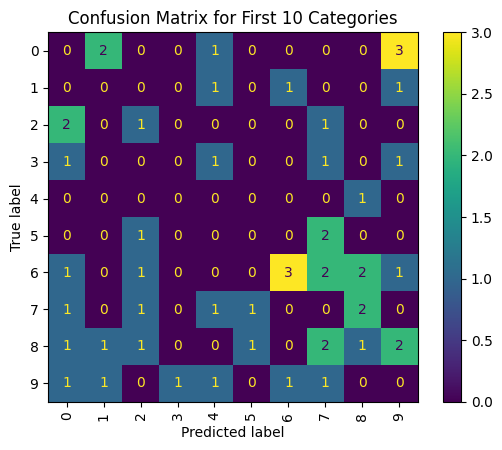

In [14]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true_classes, predicted_classes)

categories_to_display = 10
cm_subset = cm[:categories_to_display, :categories_to_display]

disp = ConfusionMatrixDisplay(confusion_matrix=cm_subset, display_labels=range(categories_to_display))
disp.plot(cmap='viridis', xticks_rotation='vertical')
plt.title(f"CNN Confusion Matrix for First {categories_to_display} Categories")
plt.show()
